Conduction instationnaire en 2D Résolution implicite - CL de type Dirichlet

$T(x,y) = T_2 + \frac{4(T_1 - T_2)}{\pi} \sum_{n=0}^{\infty} \frac{1}{2n+1} \sin\left(\frac{(2n+1)\pi x}{L_x}\right) \frac{\sinh\left(\frac{(L_y-y)(2n+1)\pi}{L_x}\right)}{\sinh\left(\frac{(2n+1)\pi L_y}{L_x}\right)}$

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [59]:
# Paramètres
Lx, Ly = 1.0, 1.0  # Dimensions
Nx, Ny = 500, 500   # Nombre de points
hx, hy = Lx / Nx, Ly / Ny  # Pas spatiaux
dt = 0.01         # Pas de temps
a = 0.01          # Diffusivité thermique
T1, T2 = 100, 0   # Températures imposées

In [60]:
# Grilles spatiales
x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
X, Y = np.meshgrid(x, y)

In [61]:
# Initialisation de la solution numérique
T_num = np.ones((Ny+1, Nx+1)) * T2
T_num[0,:] = T1  # CL sur y=0

In [62]:
# Fonction analytique pour T(x, y)
def T_analytique(x, y, T1, T2, Lx, Ly, N_terms=50):
    T = T2
    for n in range(N_terms):
        coef = (4 * (T1 - T2)) / (math.pi * (2*n + 1))
        sin_term = np.sin((2*n + 1) * math.pi * x / Lx)
        sinh_num = np.sinh((Ly - y) * (2*n + 1) * math.pi / Lx)
        sinh_den = np.sinh((2*n + 1) * math.pi * Ly / Lx)
        T += coef * sin_term * sinh_num / sinh_den
    return T


In [63]:
# Méthode numérique simple : itération explicite
alpha_x = a * dt / hx**2
alpha_y = a * dt / hy**2
t_max = 0.1
nt = int(t_max / dt)

for t in range(nt):
    T_new = T_num.copy()
    for i in range(1, Ny):
        for j in range(1, Nx):
            T_new[i, j] = T_num[i, j] + alpha_x * (T_num[i, j+1] - 2*T_num[i, j] + T_num[i, j-1]) \
                                       + alpha_y * (T_num[i+1, j] - 2*T_num[i, j] + T_num[i-1, j])
    T_num = T_new.copy()

In [64]:
# Calcul de la solution analytique
T_exact = T_analytique(X, Y, T1, T2, Lx, Ly)

In [65]:
# Calcul de la différence
T_diff = np.abs(T_exact - T_num)

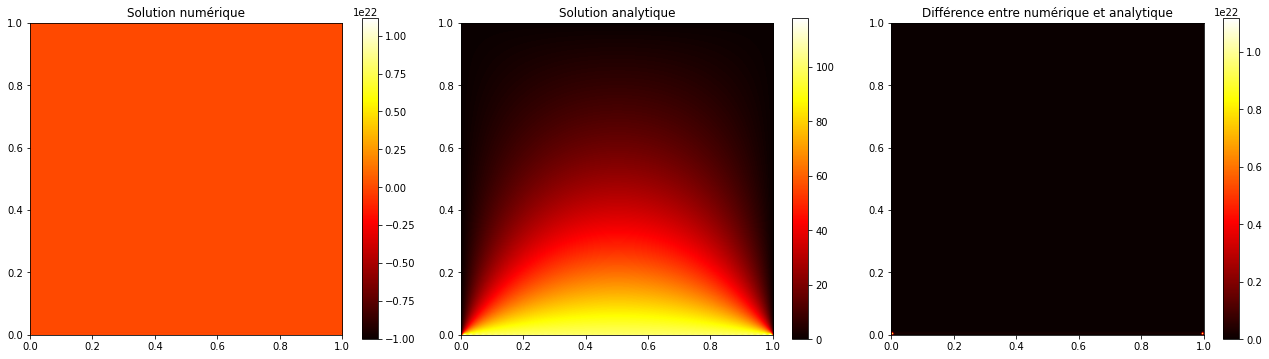

In [66]:
# Visualisation des résultats
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Solution numérique
im1 = axs[0].imshow(T_num, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot')
axs[0].set_title('Solution numérique')
fig.colorbar(im1, ax=axs[0])

# Solution analytique
im2 = axs[1].imshow(T_exact, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot')
axs[1].set_title('Solution analytique')
fig.colorbar(im2, ax=axs[1])

# Différence
im3 = axs[2].imshow(T_diff, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot')
axs[2].set_title('Différence entre numérique et analytique')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()